# Matching Grid Experiment
Here the grids used for sampling test points for human experiment were exactly replicated for the machine. The number of sampled points for both human and machine is expected to be identical after the matching procedure.


In [1]:
# changing cwd
%cd ..

c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp


## Load packages

In [2]:
from src.inductive_bias import IB
ib = IB() #instantiate inductive bias package

[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\SimulationData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\PosteriorData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\TrainedCLF.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\EstimatedData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\HellingerData.pickle ] loaded
Size of the S-XOR: (6322,)                    
Size of the Spiral: (6276,)                    
Size of the whole dataset: (12598, 7)

Size of the S-XOR after adding hellinger: (6322, 8)            
Size of the Spiral after adding hellinger: (6276, 8)


In [3]:
ib.load_sampledData()

[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\SampledData.pickle ] loaded


## Time and Date of the experiment

In [4]:
print(ib.date)

2021-05-25 19:07:16.013371


## Load dependencies

In [5]:
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

cmap = 'PRGn'

import warnings
warnings.filterwarnings('ignore')

#image output
import os
import imageio

## Extract human coordinates

In [6]:
ib.extract_human_coord()

User sequence match and dataframe exported


In [7]:
ib.humanLoc[0][0].head()

,3,5
336,-2.59,0.74
337,0.56,1.55
338,-2.05,-0.7
339,2.27,-1.78
340,1.46,-0.61


## Retraining ML models and predicting exactly the same xy coordinates from human experiment

In [8]:
ib.mask = ib.generate_mask(h=0.1)
ib.mask.shape

(3600, 2)

In [9]:
#generic global
uX = ib.mask
uX0, uX1 = uX[:,0], uX[:,1]
label = ib.mtype[:3] + ['Human'] #excluding QDA
dtype = ib.dtype[2:5:2]
fsize = 18

#retrain global
reps = 126
saved_clf = ib.clf #using already optimized hyper-parameter from previous models
N_sample = 100 #same number of samples that of human
h = 0.1
rng = 3

#train
TRAIN_NOW = True

#figure
SAVEFIG = True

In [10]:
# run only for the first time
if TRAIN_NOW:
    ib.get_sampledData(saved_clf=saved_clf, reps=reps, N_sample=N_sample, h=0.1, rng=3)


saving current attributes..
completed after 0 seconds
saved as [ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\SampledData.pickle ]


## The grid matching yields equal number of points between human and machine

In [42]:
# ML grid vs human grid
ib.estpst_sample[0][0].shape, ib.human[0].shape, ib.estpst_sample[1][0].shape, ib.human[1].shape

((6276, 3), (6276, 8), (6322, 3), (6322, 8))

## The grid size matches after point-wise averaging

In [55]:
ib.pointwise_gridAverage(ib.estpst_sample[0][0]).shape, ib.pointwise_gridAverage(np.column_stack([ib.human[0][:,3], ib.human[0][:,5], ib.human[0][:,0]])).shape

((3497, 3), (3497, 3))

In [56]:
ib.pointwise_gridAverage(ib.estpst_sample[1][0]).shape, ib.pointwise_gridAverage(np.column_stack([ib.human[1][:,3], ib.human[1][:,5], ib.human[1][:,0]])).shape

((3098, 3), (3098, 3))

## Point-wise averaging and gaussian smoothing estimated posterior

In [12]:
mtype = []
ib.mask = ib.generate_mask(h=0.1)

for ii in range(2): #S-XOR and spiral
    mtype.append([])
    
    for jj in range(4):
        if jj == 3:
            mtype_i = np.column_stack([ib.human[ii][:,3], ib.human[ii][:,5], ib.human[ii][:,0]]) # human estimates
        else:
            mtype_i = ib.estpst_sample[ii][jj] # ML estimates        
        
        mtype_i = ib.pointwise_gridAverage(mtype_i).to_numpy()        
        xy, original, down, alls = ib.smooth_gaussian_distance(mtype_i, step=0.01, method=None, sigma=1, k=10)
        mtype[ii].append(alls)

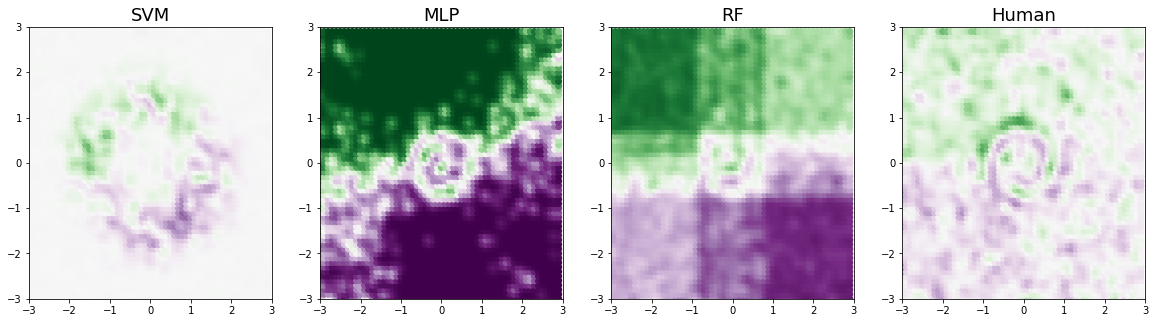

In [68]:
fig, axs = plt.subplots(1,4,figsize = (5*4,5))

for i in range(4):
    mlp = axs[i].scatter(ib.mask[:,0], ib.mask[:,1], c=mtype[0][i], cmap=cmap, vmin=0, vmax=1)
    axs[i].set_title(label[i], fontsize=18)
    axs[i].set_xlim([-3,3])
    axs[i].set_ylim([-3,3])
    if SAVEFIG:
        plt.savefig(f'figs/[20210518_matching_grid]_model_display_spiral_{str(ib.date.date())}.jpg', bbox_inches='tight')

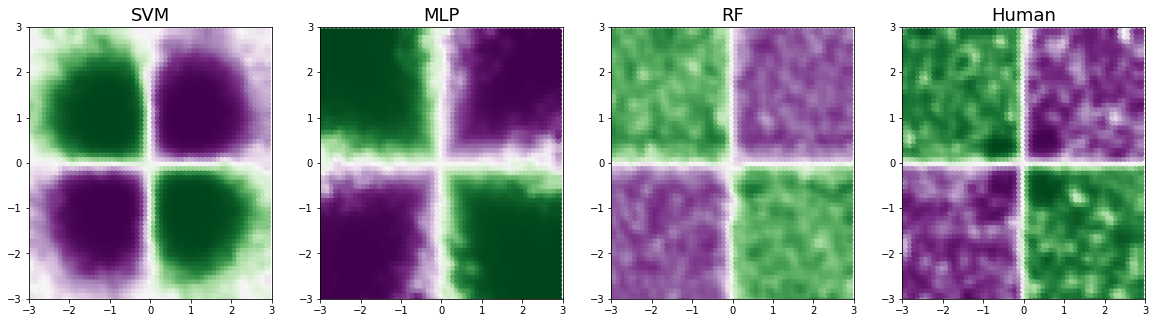

In [69]:
fig, axs = plt.subplots(1,4,figsize = (5*4,5))

for i in range(4):
    axs[i].scatter(ib.mask[:,0], ib.mask[:,1], c=mtype[1][i], cmap=cmap, vmin=0, vmax=1)
    axs[i].set_title(label[i], fontsize=18)
    axs[i].set_xlim([-3,3])
    axs[i].set_ylim([-3,3])
    if SAVEFIG:
        plt.savefig(f'figs/[20210518_matching_grid]_model_display_sxor_{str(ib.date.date())}.jpg', bbox_inches='tight')

## Generate compiled plot and output images

In [59]:
angle_step = 12
new_dtype = ['Original'] + dtype
fdtype = ['spiral', 'sxor'] #dtype defined for filename

col = 6
row = 2

step = 0.2
r = 4
x_range = np.arange(-r,r,step)

for sw, lb in enumerate(fdtype):
    for deg in np.arange(0, 180+angle_step, angle_step):

        line_plot = []
        line_post = []

        fig, axs = plt.subplots(row,col,figsize = (5*(col+2),5*row))
        # camera = Camera(fig)
        gs = axs[0, 4].get_gridspec()

        # remove the underlying axes
        for ax in axs[:, -1]:
            ax.remove()

        for ax in axs[:, -2]:
            ax.remove()

        for i in range(2):    
            line_plot.append([])
            line_post.append([])

            for j in range(4):
                line_plot[i].append([])
                line_post[i].append(ib.select_linear_region(mtype[i][j], degree=deg, step=0.001))
                
                lp, li = line_post[i][j] #line posterior, line index
                x = ib.mask[li][:,0]
                y = ib.mask[li][:,1]
                dist = np.sqrt(x**2 + y**2)

                dist[y < 0] *= -1 # negative radial distance wrt y-coordinate

                for rad in x_range:              
                    line_plot[i][j].append(np.array(lp[(dist >= rad) * (dist < rad+step)]).mean())

        for m in range(2):
            for i in range(4):
                if m == 0:
                    axs[m,i].scatter(ib.mask[:,0], ib.mask[:,1], c=mtype[sw][i], cmap=cmap, vmin=0, vmax=1) #switch here
                    
                else:
                    ibXY = ib.mask[line_post[m-1][i][1]]
                    axs[m,i].scatter(ibXY[:,0], ibXY[:,1], c=line_post[sw][i][0], cmap=cmap, vmin=0, vmax=1)

                # figure styling
                if m == 0:
                    axs[m,i].set_title(label[i], fontsize=18)

                if i == 0:
                    axs[m,i].set_ylabel(new_dtype[m], fontsize=18)

                axs[m,i].set_xlim(-3,3)
                axs[m,i].set_ylim(-3,3)
                # axs[m,i].set_xticks([])
                # axs[m,i].set_yticks([])
                
        axbig = fig.add_subplot(gs[:, -2:])

        tempdf = pd.DataFrame(np.array(line_plot[sw]).T, columns=label) #switch here
        tempdf.index = x_range
        sns.lineplot(data=tempdf, ax=axbig)

        axbig.set_title(['Spiral', 'S-XOR'][sw], fontsize=18)
        axbig.set_ylabel('mean posterior', fontsize=18)
        axbig.set_xlabel('distance from origin', fontsize=18)
        axbig.set_ylim([-0.1,1.1])
        axbig.set_xlim(-3,3)

        # camera.snap()
        # plt.pause(0.5)

        if SAVEFIG:  
            plt.savefig(f'figs/[20210518_matching_grid]_fullplot_{lb}_{deg}deg_{str(ib.date.date())}.jpg', bbox_inches='tight')

        plt.clf();
    
# animation = camera.animate()
# animation.save(f'figs/[20210512_line_analysis]_posterior_animation_{str(ib.date.date())}.gif', bitrate=10000 )#writer ='imagemagick', dpi=600) fps=10

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

## Construct gif using image files

In [60]:
imgpath = 'figs'
imglist = os.listdir(imgpath)

In [61]:
filtered = [i for i in imglist if '[20210518_matching_grid]' in i]
filtered = [i for i in filtered if 'jpg' in i]

In [62]:
filtered_spiral = [i for i in filtered if 'spiral' in i]
filtered_sxor = [i for i in filtered if 'sxor' in i]

In [63]:
temp = [[],[]]

for i, lists in enumerate([filtered_spiral, filtered_sxor]):
    for filename in lists:
        if i == 0:
            s = filename.rfind('iral_')
        else:
            s = filename.rfind('sxor_')

        e = filename.rfind('deg_')
        temp[i].append(filename[s+5:e])

In [64]:
idx = np.argsort(np.array(temp[0]).astype(int))
filtered_spiral = np.array(filtered_spiral)[idx].tolist()

idx = np.argsort(np.array(temp[1]).astype(int))
filtered_sxor = np.array(filtered_sxor)[idx].tolist()

In [65]:
filtered_spiral

['[20210518_matching_grid]_fullplot_spiral_0deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_spiral_12deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_spiral_24deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_spiral_36deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_spiral_48deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_spiral_60deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_spiral_72deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_spiral_84deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_spiral_96deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_spiral_108deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_spiral_120deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_spiral_132deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_spiral_144deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_spiral_156deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_spiral_168deg_2021-05-25.jpg',
 '[20

In [66]:
filtered_sxor

['[20210518_matching_grid]_fullplot_sxor_0deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_sxor_12deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_sxor_24deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_sxor_36deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_sxor_48deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_sxor_60deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_sxor_72deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_sxor_84deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_sxor_96deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_sxor_108deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_sxor_120deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_sxor_132deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_sxor_144deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_sxor_156deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot_sxor_168deg_2021-05-25.jpg',
 '[20210518_matching_grid]_fullplot

In [67]:
if SAVEFIG:
    for fidx, filenames in enumerate([filtered_spiral, filtered_sxor]):
        images = []

        for filename in filenames:
            images.append(imageio.imread(imgpath + '/' + filename))
        imgname = f'figs/[20210518_matching_grid]_fullplot_animated_{fdtype[fidx]}_{str(ib.date.date())}.gif'
        imageio.mimsave(imgname, images, fps=2)